In [8]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD

# Dataset Exploration

Shape of MNIST images: (10000, 28, 28)


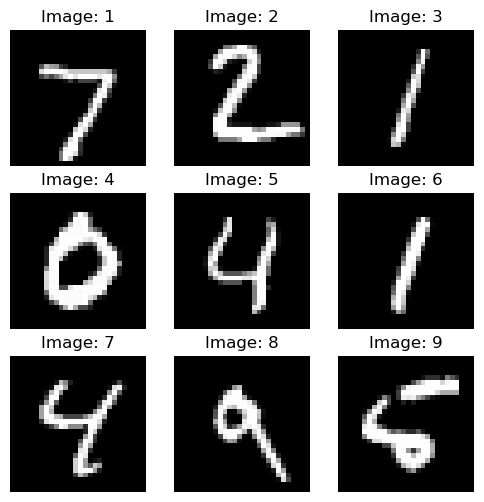

In [9]:
# make a function to get the MNIST data from a file and return it as a numpy array
def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        # Read magic number, number of images, rows, and columns
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read image data
        image_size = rows * cols
        images = np.frombuffer(f.read(image_size * num_images), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

    return images

# Provide the path to your MNIST dataset file
file_path = './datasets/10k_images.dat'

# Read MNIST images from the fileread_mnist_images(file_path)
train_data = read_mnist_images(file_path)
# Print the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# Display the first 9 images in training data
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i, axis in enumerate(ax.flat):
    axis.imshow(train_data[i], cmap='gray')
    axis.axis('off')
    axis.set(title = f'Image: {i+1}')
plt.show()



# Data Pre-processing

In [10]:
train_data = train_data.reshape(-1, 28, 28, 1)
# check the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# convert the data type to float32
train_data = train_data.astype('float32')

# check the type of the data
print(f'Type of MNIST images: {train_data.dtype}')

# normalize the data
train_data = train_data / np.max(train_data)

# check the range of the data
print(f'Range of MNIST images: {train_data.min()} to {train_data.max()}')

# parition the data into training and validation sets
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2)

# print the shape of training data and validation data
print(f'Shape of training data: {train_X.shape}')
print(f'Shape of validation data: {valid_X.shape}')

print(f'Shape of training labels: {train_ground.shape}')
print(f'Shape of validation labels: {valid_ground.shape}')

Shape of MNIST images: (10000, 28, 28, 1)
Type of MNIST images: float32
Range of MNIST images: 0.0 to 1.0
Shape of training data: (8000, 28, 28, 1)
Shape of validation data: (2000, 28, 28, 1)
Shape of training labels: (8000, 28, 28, 1)
Shape of validation labels: (2000, 28, 28, 1)


# The Convolutional Autoencoder

In [11]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

In [12]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)  # Batch normalization added
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (7, 7), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)  # Batch normalization added
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)  # Batch normalization added

    # Latent dimension (change the size as needed)
    latent_dim = 64
    bottleneck = Conv2D(latent_dim, (7, 7), activation='relu', padding='same')(conv3)
    bottleneck = BatchNormalization()(bottleneck)  # Batch normalization added

    # Decoder
    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(bottleneck)
    conv4 = BatchNormalization()(conv4)  # Batch normalization added
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (7, 7), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)  # Batch normalization added
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(up2)

    return decoded

# Create the model
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer= RMSprop(0.01))

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        100416    
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256 

# Train the model

In [13]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10


63/63 [==============================] - 66s 1s/step - loss: 0.1330 - val_loss: 0.1262
Epoch 2/10
63/63 [==============================] - 70s 1s/step - loss: 0.0943 - val_loss: 0.1487
Epoch 3/10
63/63 [==============================] - 59s 936ms/step - loss: 0.0597 - val_loss: 0.0984
Epoch 4/10
63/63 [==============================] - 58s 928ms/step - loss: 0.0371 - val_loss: 0.0852
Epoch 5/10
63/63 [==============================] - 50s 795ms/step - loss: 0.0267 - val_loss: 0.0487
Epoch 6/10
63/63 [==============================] - 53s 839ms/step - loss: 0.0218 - val_loss: 0.0310
Epoch 7/10
63/63 [==============================] - 47s 747ms/step - loss: 0.0174 - val_loss: 0.0479
Epoch 8/10
63/63 [==============================] - 47s 749ms/step - loss: 0.0136 - val_loss: 0.0395
Epoch 9/10
63/63 [==============================] - 52s 817ms/step - loss: 0.0116 - val_loss: 0.0203
Epoch 10/10
63/63 [==============================] - 46s 731ms/step - loss: 0.0103 - val_loss: 0.0100


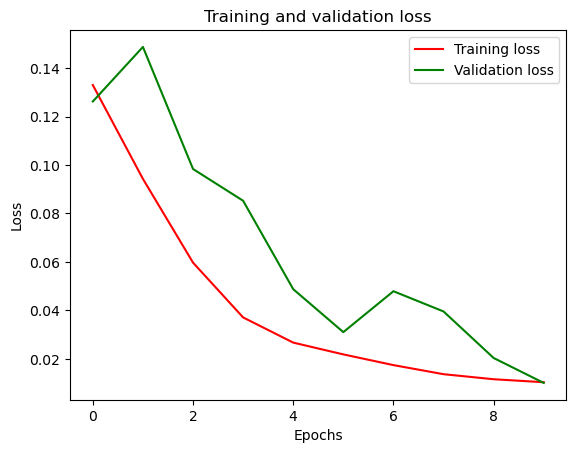

In [14]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()